In [1]:
# Importieren von Bibliotheken die benötigt werden
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_profiling
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time

# Definiere Farben für Plots
fh_teal = '#179c7d'
fh_orange = '#f29400'
fh_blue = '#1f82c0'
fh_red = '#e2001a'
fh_lightgreen = '#b1c800'
fh_beige = '#feefd6'
fh_grey = '#e1e3e3'

# Globale Einstellung für Schriftgröße, Farben usw. für Plots
fh_palette = [fh_teal, fh_orange, fh_blue, fh_red, fh_lightgreen, fh_beige, fh_grey]
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette(fh_palette)
params = {'legend.fontsize': 22,
          'figure.figsize': (20, 14),
          'axes.labelsize': 22,
          'axes.titlesize': 26,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'font.sans-serif': 'Frutiger LT Com'}
mpl.rcParams.update(params)

# Initial Data Exploration

In [2]:
# names for columns of data
index = ["unit#","tCycles"]
settings = ["setting1","setting2","setting3"]
sensors = ["sensor" + str(i) for i in range(1,22)]
col_names = index + settings + sensors + ["dropa","dropb"]

In [3]:
# Laden der Trainingsdaten
df_train = pd.read_csv("./CMAPSSData/train_FD001.txt",sep=" ", names=col_names)

In [4]:
# drop useless columns
drop_cols = ["setting3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "dropa", "dropb"]
df_train.drop(drop_cols,axis=1, inplace=True)

In [5]:
# Definition der remaining useful time (RUL)
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df_train.groupby(by="unit#")
    max_cycle = grouped_by_unit["tCycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df_train.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit#', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["tCycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
df_train = add_remaining_useful_life(df_train)

In [6]:
# Laden der Testdaten
df_test = pd.read_csv("./CMAPSSData/test_FD001.txt",sep=" ", names=col_names)
df_test = df_test.drop(["dropa", "dropb"],axis=1)
df_test.drop(["setting3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19"],axis=1, inplace=True)

In [7]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [8]:
X_train = df_train.copy()
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = df_test.copy()
X_test = df_test.groupby('unit#').last().reset_index()

y_test = pd.read_csv(('./CMAPSSData/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

# Modellierung

#### Importiere benötigte Bibliotheken und Funktionen

In [9]:
import tensorflow.keras as tfk
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

#### Normalisieren der Daten

In [10]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Definition der Loss Function

In [11]:
def root_mean_squared_error(y_true, y_pred):
    return tfk.backend.sqrt(tfk.backend.mean(tfk.backend.square(y_pred - y_true)))

## Zum Start ein einfaches Modell

In [12]:
# Model Definition
model_linear = LinearRegression()

In [13]:
# Model Training
model_linear.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
# Model Evaluation
y_hat_train = model_linear.predict(X_train_scaled)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = model_linear.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE:39.58546827329525, R2:0.6697111890795342
test set RMSE:31.71973384242311, R2:0.4173610358106008


## Genaue Betrachtung des RUL

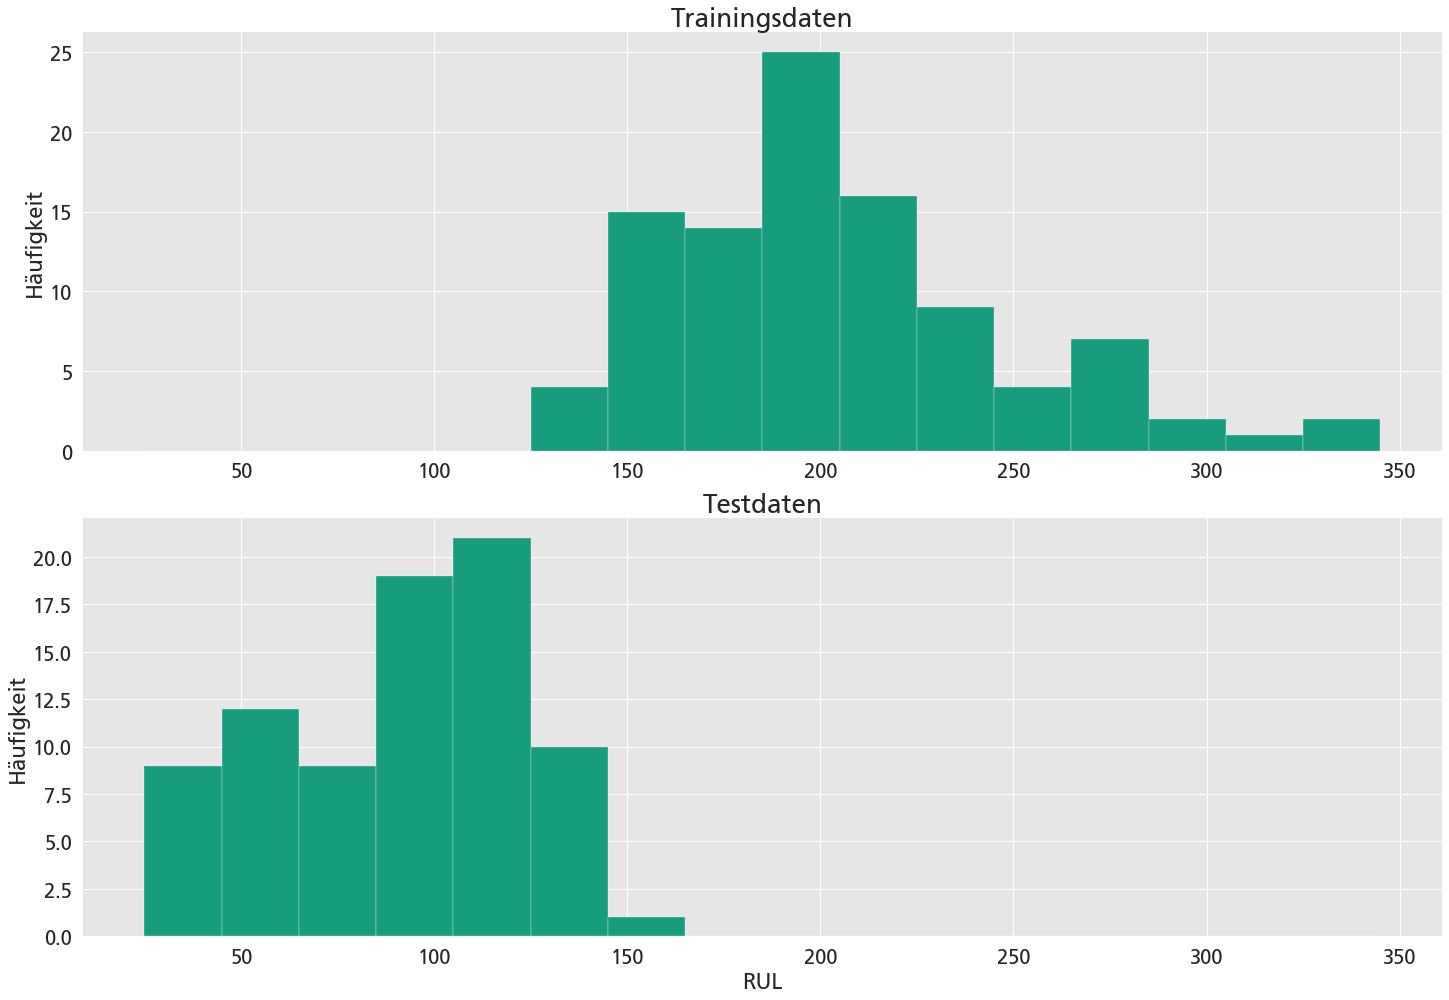

In [15]:
df_max_rul = df_train[['unit#', 'RUL']].groupby('unit#').max().reset_index()

fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(211)
df_max_rul['RUL'].hist(ax=ax, bins=range(25, 350, 20))
plt.ylabel('Häufigkeit')
plt.title('Trainingsdaten')

ax2 = fig.add_subplot(212)
y_test['RUL'].hist(ax=ax2, bins=range(25, 350, 20))
plt.xlabel('RUL')
plt.ylabel('Häufigkeit')
plt.title('Testdaten')
plt.show()

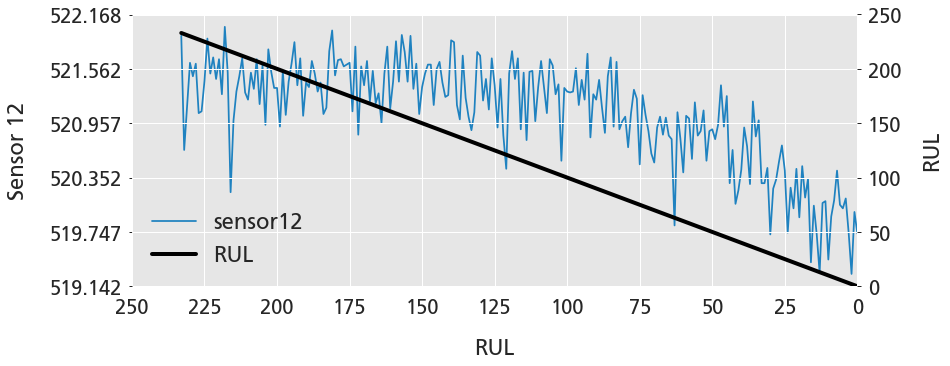

In [16]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

unit20_RUL = np.array(df_train.loc[df_train['unit#']==20, 'RUL'])
unit20_sensor12 = np.array(df_train.loc[df_train['unit#']==20, 'sensor12'])

signal = ax1.plot(unit20_RUL, unit20_sensor12, color=fh_blue)


plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('Sensor 12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot(unit20_RUL, unit20_RUL, 'k', linewidth=4)
ax2.set_ylabel('RUL', labelpad=20)

# equal spacing of y ticks for both axes, so the gridlines allign
ax2.set_ylim(0, 250)  # set limits of axis you want to display neatly
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))  # choose integer to neatly divide your axis, in our case 6
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))  # apply same spacing to other axis

# code to have a unified legend
lines = signal+rul_line
labels = ['sensor12', 'RUL']
ax1.legend(lines, labels, loc=0)


plt.show()

In [17]:
## Optimiertes RUL 
y_train_optimized = y_train.clip(upper=125)

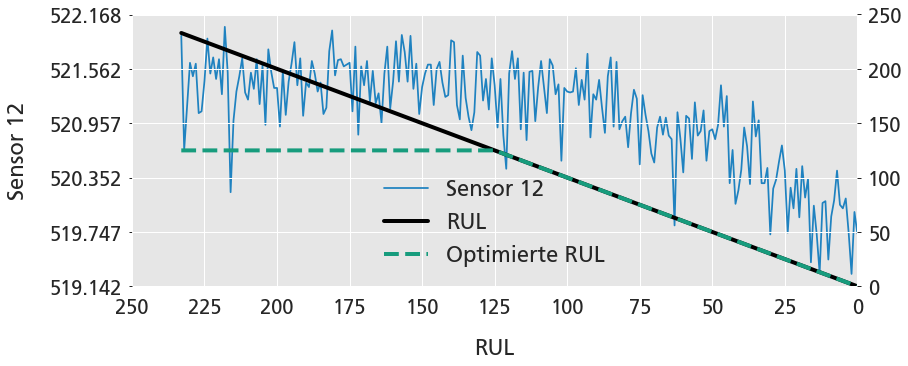

In [18]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot(unit20_RUL, unit20_sensor12, color=fh_blue)

rul = df_train.loc[df_train['unit#']==20, 'RUL']
unit20_RUL_optimized = unit20_RUL.copy()
unit20_RUL_optimized[unit20_RUL_optimized >= 125] = 125

plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('Sensor 12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot(unit20_RUL, unit20_RUL, 'k', linewidth=4)

rul_line2 = ax2.plot(unit20_RUL, unit20_RUL_optimized, '--', linewidth=4, color=fh_teal)

# equal spacing of y ticks for both axes, so the gridlines allign
ax2.set_ylim(0, 250)  # set limits of axis you want to display neatly
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))  # choose integer to neatly divide your axis, in our case 6
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))  # apply same spacing to other axis

lines = signal+rul_line+rul_line2
labels = ['Sensor 12', 'RUL', 'Optimierte RUL']
ax1.legend(lines, labels, loc=0)

#### Lineare Regression mit optimiertem RUL

In [19]:
# Model Definition
lm = LinearRegression()

# Model Training
lm.fit(X_train_scaled, y_train_optimized)

# Model Evaluation
y_hat_train = lm.predict(X_train_scaled)
evaluate(y_train_optimized, y_hat_train, 'train')
y_hat_test = lm.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE:19.827954467105034, R2:0.773612325266579
test set RMSE:22.614038309741126, R2:0.7038602517095446


# Weitere Modelle

## Model Definition

#### Definition eines Random Forest

In [20]:
model_forest = RandomForestClassifier(n_estimators=10)

#### Definition eines Neural Network (Input Layer und Output Layer)

In [21]:
inputs = tfk.Input(shape=(18,))
outputs = tfk.layers.Dense(1, activation=tfk.activations.relu)(inputs)

model_nn = tfk.Model(inputs=inputs, outputs=outputs)
model_nn.compile(optimizer='rmsprop',loss = root_mean_squared_error)

#### Definition eines Deep Neural Network (Input Layer, 3 Hidden Layer, Output Layer)

In [22]:
inputs = tfk.Input(shape=(18,))
x = tfk.layers.Dense(18, 
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(inputs)
x = tfk.layers.Dense(70, 
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(x)
x = tfk.layers.Dense(60, 
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(x)
x = tfk.layers.Dense(50, 
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(x)
x = tfk.layers.Dense(40, 
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(x)
x = tfk.layers.Dense(10,
                     activation=tfk.activations.relu,
                     kernel_initializer='glorot_normal',
                     activity_regularizer=tfk.regularizers.l1(0.00002))(x)
outputs = tfk.layers.Dense(1,
                           activation=tfk.activations.relu,
                          activity_regularizer=tfk.regularizers.l1(0.00002))(x)

model_deep_nn = tfk.Model(inputs=inputs, outputs=outputs)
model_deep_nn.compile(optimizer=tfk.optimizers.RMSprop(learning_rate=0.01),
                      loss = root_mean_squared_error,
                     metrics=[root_mean_squared_error])

#### Definition einer Support Vector Maschine (SVM)

In [23]:
supVecMac = svm.SVR(kernel='linear')

# Model Training

#### Training des Random Forest

In [24]:
model_forest.fit(X_train_scaled, y_train_optimized)
y_pred = model_forest.predict(X_train_scaled)
print('Trainingsfehler (RMSE):', np.sqrt(metrics.mean_squared_error(y_train_optimized, y_pred)))

Trainingsfehler (RMSE): 1.6064342778768466


#### Training des Neural Network

In [25]:
model_nn.fit(X_train_scaled, y_train_optimized, batch_size=10, epochs=10)

Epoch 1/10
2064/2064 [==============================] - 1s 670us/step - loss: 87.5469
Epoch 2/10
2064/2064 [==============================] - 1s 689us/step - loss: 73.2620
Epoch 3/10
2064/2064 [==============================] - 1s 640us/step - loss: 61.0743
Epoch 4/10
2064/2064 [==============================] - 1s 669us/step - loss: 52.3387
Epoch 5/10
2064/2064 [==============================] - 2s 796us/step - loss: 47.5081
Epoch 6/10
2064/2064 [==============================] - 2s 853us/step - loss: 44.9598
Epoch 7/10
2064/2064 [==============================] - 2s 894us/step - loss: 43.2852
Epoch 8/10
2064/2064 [==============================] - 2s 862us/step - loss: 41.8343
Epoch 9/10
2064/2064 [==============================] - 2s 874us/step - loss: 40.4687
Epoch 10/10
2064/2064 [==============================] - 2s 845us/step - loss: 39.1169


#### Training des Deep Neural Networks

In [26]:
model_deep_nn.fit(X_train_scaled, y_train_optimized, batch_size=10, epochs=10)

Epoch 1/10
2064/2064 [==============================] - 3s 1ms/step - loss: 22.8726 - root_mean_squared_error: 22.8419
Epoch 2/10
2064/2064 [==============================] - 3s 1ms/step - loss: 18.1551 - root_mean_squared_error: 18.1452
Epoch 3/10
2064/2064 [==============================] - 3s 1ms/step - loss: 17.1256 - root_mean_squared_error: 17.1163
Epoch 4/10
2064/2064 [==============================] - 2s 1ms/step - loss: 16.6148 - root_mean_squared_error: 16.6021
Epoch 5/10
2064/2064 [==============================] - 3s 1ms/step - loss: 16.2670 - root_mean_squared_error: 16.2550
Epoch 6/10
2064/2064 [==============================] - 3s 1ms/step - loss: 16.1465 - root_mean_squared_error: 16.1432
Epoch 7/10
2064/2064 [==============================] - 3s 1ms/step - loss: 16.0061 - root_mean_squared_error: 15.9944
Epoch 8/10
2064/2064 [==============================] - 3s 1ms/step - loss: 15.9702 - root_mean_squared_error: 15.9582
Epoch 9/10
2064/2064 [==========================

#### Training der Support Vector Machine

In [27]:
supVecMac.fit(X_train_scaled, y_train_optimized)
y_pred = supVecMac.predict(X_train_scaled)
print('Trainingsfehler (RMSE):', np.sqrt(metrics.mean_squared_error(y_train_optimized, y_pred)))

Trainingsfehler (RMSE): 19.863088515644268


# Model Evaluation

In [28]:
model_linear = linear_model.LinearRegression()
model_linear.fit(X_train_scaled, y_train_optimized)

models = [model_linear, model_forest, model_nn, model_deep_nn, supVecMac]

metric = metrics.mean_squared_error
metric_per_model = []
for model in models:
    prediction = model.predict(X_test_scaled)
    cost = metric(y_test, prediction)
    cost = np.sqrt(cost)
    metric_per_model.append(cost)
    


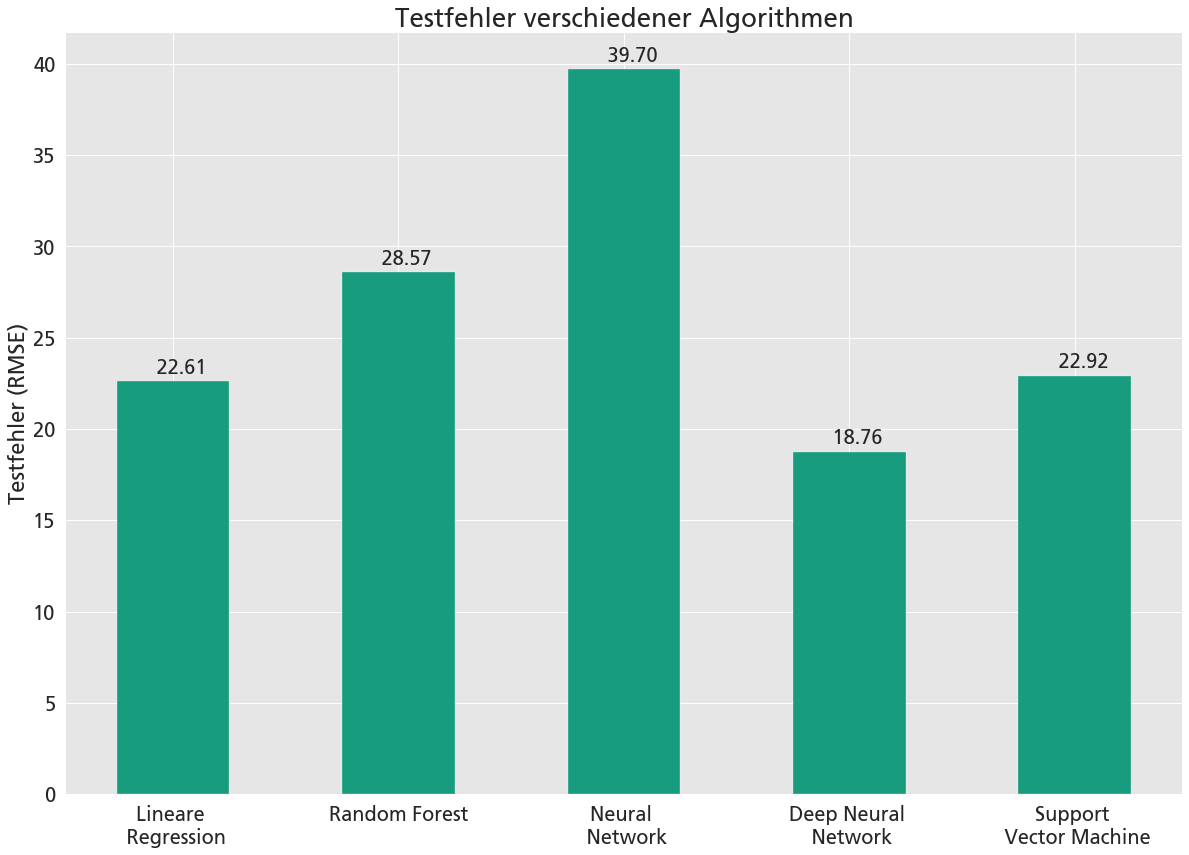

In [29]:
x = np.arange(len(metric_per_model))
model_names = ['Lineare \n Regression', 'Random Forest', 'Neural \n Network', 'Deep Neural \n Network', 'Support \n Vector Machine']


fig, ax = plt.subplots()
bar = ax.bar(x, metric_per_model, .5)
plt.xticks(x,[model for model in model_names])

for rect in bar:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., .2 + height,
            '%8.2f' % height,
            ha='center', va='bottom',
            fontsize=20)

plt.title('Testfehler verschiedener Algorithmen')
plt.ylabel('Testfehler (RMSE)');

# Hyperparamter

#### Welches sind die optimaten Hyperparamter für einen Random Forest

In [30]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10, 25, 50, 100, 250, 500],
            "max_features"      : ["sqrt", "log2"],
            "min_samples_split" : [2,4,8,16, 32],
            "bootstrap": [True, False]
            }

    random_params = RandomizedSearchCV(estimator, param_grid, n_iter=20, n_jobs=-1, cv=5)

    random_params.fit(X_train, y_train)

    return random_params.best_score_ , random_params.best_params_

def RFR(X_train, X_test, y_train, y_test, best_params):
    from sklearn.ensemble import RandomForestRegressor
    estimator = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    return y_test,y_predict

In [31]:
best_score, best_params = Grid_Search_CV_RFR(X_train_scaled, y_train_optimized)
y_test , y_predict = RFR(X_train_scaled, X_test_scaled, y_train_optimized, y_test, best_params)
print("Best Score:" ,best_score)
print("Best params:",best_params)

Best Score: 0.8348333452173462
Best params: {'n_estimators': 500, 'min_samples_split': 16, 'max_features': 'sqrt', 'bootstrap': True}


#### Der Random Forest mit den optimalen Hyperparametern

In [33]:
model_forest2 = RandomForestClassifier(bootstrap=True, max_features='log2', n_estimators=100)
model_forest2.fit(X_train_scaled, y_train_optimized)
y_pred = model_forest2.predict(X_train_scaled)

In [34]:
y_pred = model_forest2.predict(X_test_scaled)
print('Testfehler (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Testfehler (RMSE): 26.1721225734559


In [35]:
models2 = [model_linear, model_forest, model_forest2, model_nn, model_deep_nn, supVecMac]

metric = metrics.mean_squared_error
metric_per_model2 = []
for model in models2:
    prediction = model.predict(X_test_scaled)
    cost = metric(y_test, prediction)
    cost = np.sqrt(cost)
    metric_per_model2.append(cost)

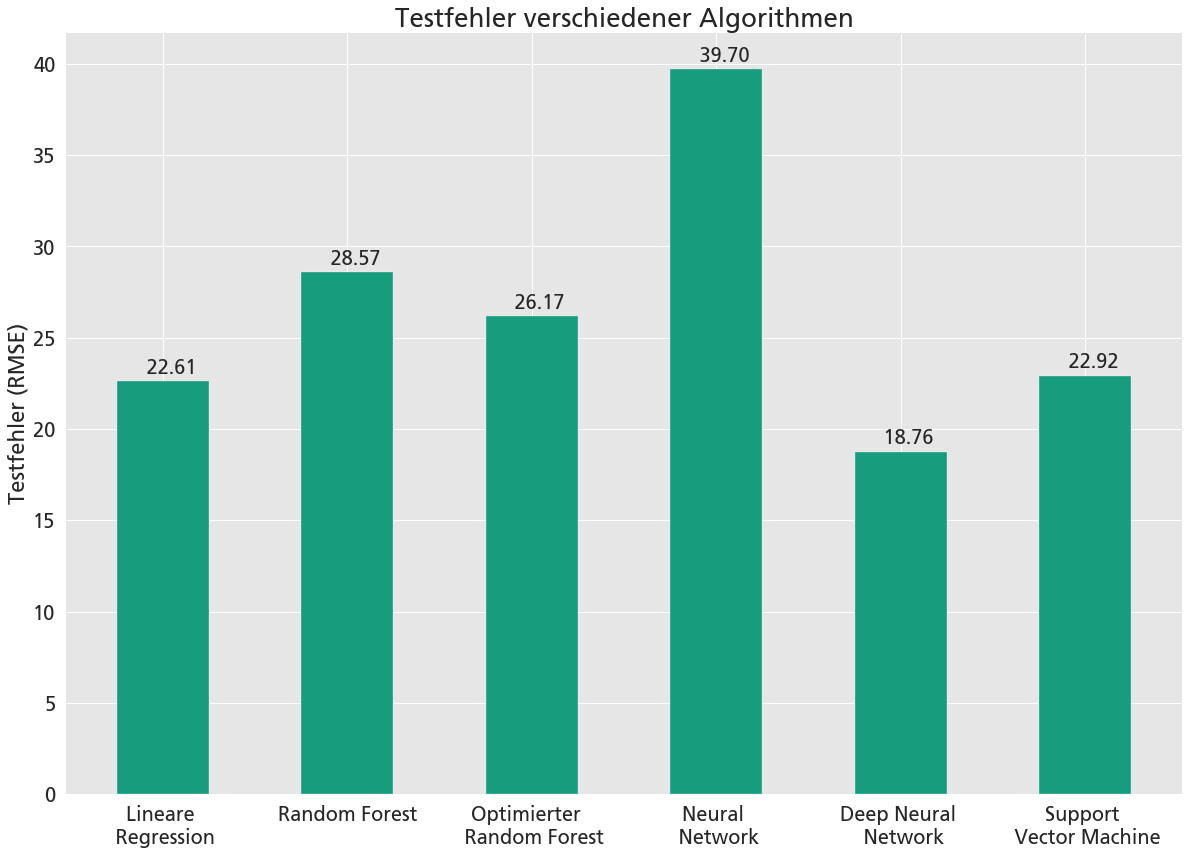

In [36]:
x = np.arange(len(metric_per_model2))
model_names2 = ['Lineare \n Regression', 'Random Forest', 'Optimierter  \n Random Forest', 'Neural \n Network', 'Deep Neural \n Network', 'Support \n Vector Machine']


fig, ax = plt.subplots()
bar = ax.bar(x, metric_per_model2, .5)
plt.xticks(x,[model for model in model_names2])

for rect in bar:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., .2 + height,
            '%8.2f' % height,
            ha='center', va='bottom',
            fontsize=20)

plt.title('Testfehler verschiedener Algorithmen')
plt.ylabel('Testfehler (RMSE)');

In [37]:
%load_ext watermark

# python, ipython, packages and machine characteristics
%watermark -v -m -p pandas_profiling,pandas,numpy,matplotlib,seaborn,time,watermark,sklearn,tensorflow

#date
print(" ")
%watermark -u -n -t -z


Python implementation: CPython
Python version       : 3.7.4
IPython version      : 7.13.0

pandas_profiling: 2.5.0
pandas          : 1.1.4
numpy           : 1.18.2
matplotlib      : 3.1.2
seaborn         : 0.9.0
time            : unknown
watermark       : 2.2.0
sklearn         : 0.0
tensorflow      : 2.2.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit

 
Last updated: Wed Jun 02 2021 09:26:34Mitteleuropäische Sommerzeit

